# ------------------------------------------ Current Trends: --------------------------------------

### Task#30: Signal Processing using NN(Neural Network) -> Basics 

### Task#31: Signal Processing using CNN Basics

### Task#32: Signal Processing using RNN Basics

In [1]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


In [3]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)


/home/hasanmdmehadi/@@ACADEMIC_FILES/4-2/DSP/Lab assignments
Compressed_rsTest.jpg				      LICENSE
Compressed_sm.jpg				      LSTM_files
Compressed_test.jpg				      LSTM.ipynb
data						      plot.png
DSP Lab Assignments and Projects [2014-15] - MHN.pdf  README.md
DSP Practice.ipynb				      rsTest.jpg
Evolutionary Learning(Genetic Algorithm).ipynb	      sm.jpg
Lab_task (copy).ipynb				      test.jpg
Lab_task.ipynb					      test.wav
/home/hasanmdmehadi/@@ACADEMIC_FILES/4-2/DSP/Lab assignments/data
download_dataset.py  source.txt

Downloading...
--2019-01-05 22:48:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.

In [4]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep

# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)

# Training 
learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.0991399 0.395671
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [6]:
def LSTM_RNN(_X, _weights, _biases):
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many-to-one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes 
    # e.g.: 
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [8]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


Training iter #1500:   Batch Loss = 3.194663, Accuracy = 0.12333333492279053
PERFORMANCE ON TEST SET: Batch Loss = 2.5217666625976562, Accuracy = 0.25381743907928467
Training iter #30000:   Batch Loss = 1.374934, Accuracy = 0.70333331823349
PERFORMANCE ON TEST SET: Batch Loss = 1.4910149574279785, Accuracy = 0.6667797565460205
Training iter #60000:   Batch Loss = 1.171587, Accuracy = 0.7526666522026062
PERFORMANCE ON TEST SET: Batch Loss = 1.2827613353729248, Accuracy = 0.7434679269790649
Training iter #90000:   Batch Loss = 0.991930, Accuracy = 0.846666693687439
PERFORMANCE ON TEST SET: Batch Loss = 1.2063946723937988, Accuracy = 0.8025110363960266
Training iter #120000:   Batch Loss = 0.908134, Accuracy = 0.8799999952316284
PERFORMANCE ON TEST SET: Batch Loss = 1.2392683029174805, Accuracy = 0.7923311591148376
Training iter #150000:   Batch Loss = 0.848826, Accuracy = 0.9386666417121887
PERFORMANCE ON TEST SET: Batch Loss = 1.0743350982666016, Accuracy = 0.8625721335411072
Training i

/home/hasanmdmehadi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


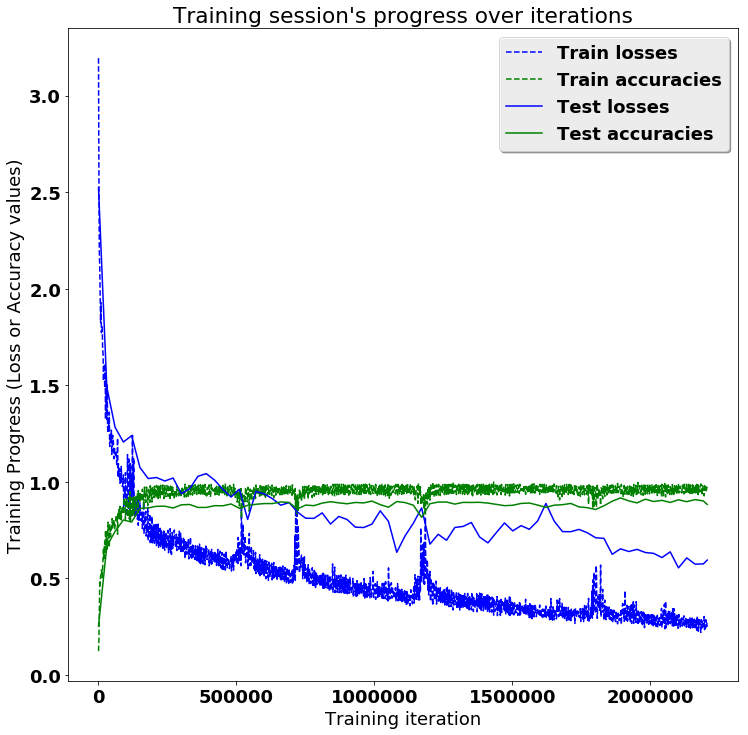

In [9]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

Testing Accuracy: 88.32710981369019%

Precision: 88.57760743767463%
Recall: 88.32711231761114%
f1_score: 88.34253532475897%

Confusion Matrix:
[[444  23  29   0   0   0]
 [  8 460   1   0   2   0]
 [  2  18 400   0   0   0]
 [  0   1   0 361 129   0]
 [  1   1   0 103 427   0]
 [  0  26   0   0   0 511]]

Confusion matrix (normalised to % of total test data):
[[ 15.06616879   0.7804547    0.98405153   0.           0.           0.        ]
 [  0.2714625   15.60909462   0.03393281   0.           0.06786563   0.        ]
 [  0.06786563   0.61079061  13.57312489   0.           0.           0.        ]
 [  0.           0.03393281   0.          12.24974537   4.37733269   0.        ]
 [  0.03393281   0.03393281   0.           3.49507976  14.48931122   0.        ]
 [  0.           0.88225317   0.           0.           0.          17.33966827]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier i

/home/hasanmdmehadi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


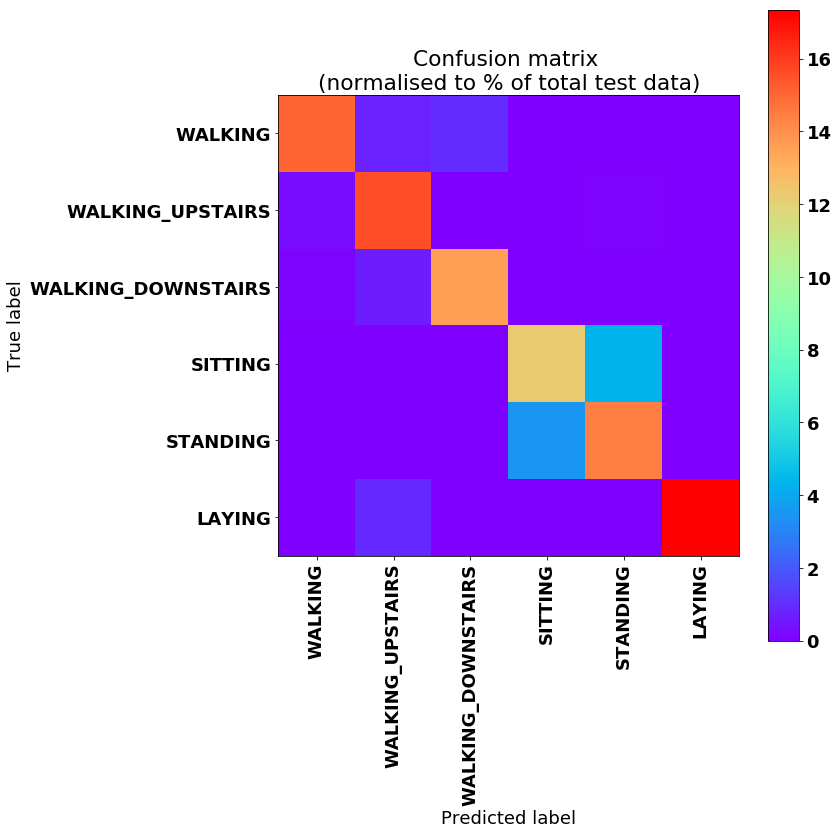

In [10]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [11]:
sess.close()

# Extra

/home/hasanmdmehadi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


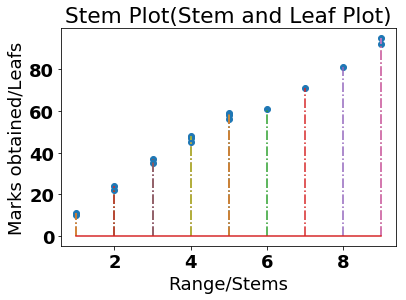

In [37]:
##Stem plot:
import matplotlib.pyplot as plot
import numpy as np
marks = [10,11,22,24,35,37,45,47,48,58,56,59,61,71,81,92,95]
stems = [1,1,2,2,3,3,4,4,4,5,5,5,6,7,8,9,9]
plot.title('Stem Plot(Stem and Leaf Plot)')
plot.xlabel('Range/Stems')
plot.ylabel('Marks obtained/Leafs')
plot.stem(stems, marks, '-.')
plot.show()

/home/hasanmdmehadi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


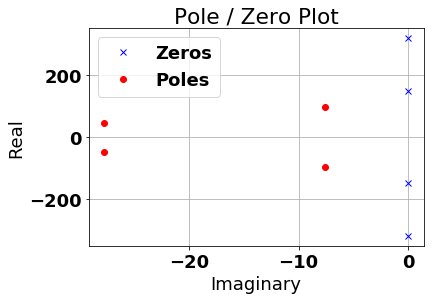

In [38]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
b, a = signal.iirdesign(wp=100, ws=200, gpass=2.0, gstop=40., analog=True)
z, p, k = signal.tf2zpk(b, a)
plt.plot(np.real(z), np.imag(z), 'xb')
plt.plot(np.real(p), np.imag(p), 'or')
plt.legend(['Zeros', 'Poles'], loc=2)
plt.title('Pole / Zero Plot')
plt.ylabel('Real')
plt.xlabel('Imaginary')
plt.grid()
plt.show()